In [1]:
import pyaerocom as pya
import matplotlib.pyplot as plt
import pyaerocom as pya
from pyaerocom.io.readungridded import ReadUngridded
from pyaerocom.io.readgridded import ReadGridded
from pyaerocom.io.helpers_units import (unitconv_sfc_conc_bck, 
                                        unitconv_sfc_conc, 
                                        unitconv_wet_depo_bck,
                                        unitconv_wet_depo, unitconv_wet_depo_from_emep)
import pandas as pd
import numpy as np
from pyaerocom.plot import df_to_heatmap
from pyaerocom import Filter
from pyaerocom.mathutils import calc_statistics 

%matplotlib inline

Initating pyaerocom configuration
Checking database access...
Checking access to: /lustre/storeA
Access to lustre database: True
Init data paths for lustre
Expired time: 0.013 s
/home/hannas/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hannas/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
pya.browse_database('*fss*CTRL*')


Pyaerocom ReadGridded
---------------------
Data ID: GFDL-AM4-fSST_AP3-CTRL
Data directory: /lustre/storeA/project/aerocom/aerocom-users-database/AEROCOM-PHASE-III-2019/GFDL-AM4-fSST_AP3-CTRL/renamed
Available experiments: ['AP3-CTRL']
Available years: [2010]
Available frequencies ['monthly' 'daily']
Available variables: ['abs550aer', 'ac550aer', 'airmass', 'areacella', 'cdnc', 'chepsoa', 'clt', 'dh', 'drybc', 'drydust', 'drypoa', 'dryso4', 'drysoa', 'dryss', 'ec550aer', 'emibc', 'emidust', 'emipoa', 'emiso2', 'emiss', 'hur', 'loadbc', 'loaddu', 'loadlgdst', 'loadoc', 'loadsmdst', 'loadso4', 'loadss', 'mmrbc', 'mmrdust', 'mmrlgdst', 'mmroa', 'mmrpm1', 'mmrpm10', 'mmrpm2p5', 'mmrsmdst', 'mmrso4', 'mmrss', 'od550aer', 'od550bc', 'od550dust', 'od550lgdst', 'od550lt1aer', 'od550oa', 'od550smdst', 'od550so4', 'od550ss', 'od870aer', 'orog', 'pr', 'ps', 'q', 'rho', 'rlds', 'rldscs', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'sftlf', 'ta', 'tas', 

In [3]:
def construct_df_model_intercomparison_to_observations(vars_to_retrieve = 'wetso4', 
                                                       OBS_network = 'GAWTADsubsetAasEtAl', 
                                                       list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 
                                                                        'CAM5-ATRAS_AP3-CTRL', 
                                                                        #'GFDL-AM4-met2010_AP3-CTRL', 
                                                                        #'GFDL-AM4-fSST_AP3-CTRL'
                                                                       ],
                                                       add_yearly = 'mean',
                                                       start = 2010,
                                                       bias = True, 
                                                       rmse = True, 
                                                       region = None):
    """
    Parameters
    ----------
    vars_to_retrieve : str
            'wetso4', 
    OBS_network : str
        'GAWTADsubsetAasEtAl', 
    list_model_ID : list[str]
        ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL'], 
    start : int,
        defalt = 2010,
    bias : bool
        default True 
    rmse : bool, 
        default True, 
    region : str
    
    Returns 
    ------------------
    df : DataFrame 
    
    Notes
    ----------------------------
    Available regions :
    ['WORLD',
     'EUROPE',
     'ASIA',
     'AUSTRALIA',
     'CHINA',
     'INDIA',
     'NAFRICA',
     'SAFRICA',
     'SAMERICA',
     'NAMERICA']

    """    
    ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)
    
    # TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).
    
    #if region is not None:
    #    f              = Filter(region=region)
    #    ungridded_data = f(ungridded_data)
        
    station_names     = ungridded_data.station_name
    list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                         for ID in list_model_ID ]
    
    # Possible to retrieve ts type of obeservation 
    list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, 
                                                               ungridded_data, 
                                                               ts_type='monthly').apply_latlon_filter(region_id = 
                                                                                                      "EUROPE")
                    for gridded_data in list_gridded_data]

    # call merged : raw, bias : Bias, rmse : RMSE 
    def fix_df(df):
        df = df.unstack('data_source').swaplevel().unstack('station_name')
        df2 = df['wetso4']

        df2.columns = df2.columns.swaplevel(0,1)
        df2.sort_index(axis = 1, level = (0, 1), inplace = True)
        return df2
    
    dataframes = [ coloc.data.to_dataframe().drop(columns=['var_name', 'var_units','ts_type_src','altitude', 
                                                           'latitude', 'longitude']) for coloc in list_colocate ]
    dataframes = [fix_df(df) for df in dataframes]
    
    for df in dataframes:
        df.append(df.mean(axis = 0).rename('year'), ignore_index = True)

    # TODO finish this ,.,.,.,.,., 
    seasonal_means = [ coloc.data.groupby('time.season').mean(dim = 'time') for coloc in list_colocate ]
    df_seasons = [fix_df(seasonal_mean.to_dataframe()) for seasonal_mean in seasonal_means]
    
    lala = pd.concat(dataframes, axis = 1)
    lala.sort_index(axis = 1, level = (0, 1), inplace = True)
    df = lala.loc[:, ~lala.columns.duplicated()]
    
    # TODO : Update yearly based on function sent as input
    #df.index = ['jan', 'feb', 'mar', 'apr', 'mai', 'jun', 'jul', 'aug', 'sep', 'okt', 'nov', 'des', 'year']
        
    # Add bias and rmse 
    m = []
    station_names = df.columns.levels[0].values

    for name in station_names:
        obs      = 'GAWTADsubsetAasEtAl'
        station  = df[name]

        df_obs   = pd.DataFrame(station[obs])
        df_model = station.drop(obs, axis = 1)
        
        tot  = [df_obs, df_model]
        keys = ['obs', 'model']
        
        if bias:
            b = df_model - df_obs.values
            tot.append(b)
            keys.append('bias')
            
        if rmse:
            r = np.sqrt( (df_model - df_obs.values)**2)
            tot.append(r) 
            keys.append('rmse')
    
        merged = pd.concat(tot, axis = 1, keys = keys)
        m.append(merged)
        
    df = pd.concat(m, axis = 1, keys = station_names)
    return df

In [4]:
#df = construct_df_model_intercomparison_to_observations(region = 'NAMERICA', bias = True, rmse = True);

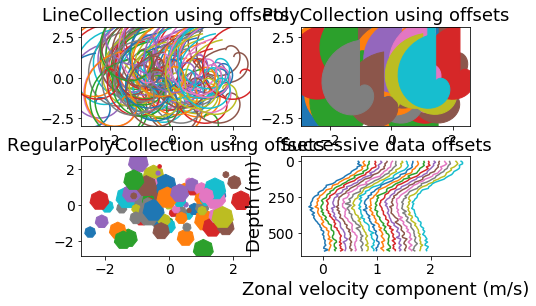

In [5]:
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
import numpy as np

nverts = 50
npts = 100

# Make some spirals
r = np.arange(nverts)
theta = np.linspace(0, 2*np.pi, nverts)
xx = r * np.sin(theta)
yy = r * np.cos(theta)
spiral = list(zip(xx, yy))

# Make some offsets
rs = np.random.RandomState([12345678])
xo = rs.randn(npts)
yo = rs.randn(npts)
xyo = list(zip(xo, yo))

# Make a list of colors cycling through the default series.
colors = [colors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

fig, axes = plt.subplots(2, 2)
fig.subplots_adjust(top=0.92, left=0.07, right=0.97,
                    hspace=0.3, wspace=0.3)
((ax1, ax2), (ax3, ax4)) = axes  # unpack the axes

col = collections.LineCollection([spiral], offsets=xyo,
                                 transOffset=ax1.transData)
trans = fig.dpi_scale_trans + transforms.Affine2D().scale(1.0/72.0)
col.set_transform(trans)  # the points to pixels transform
# Note: the first argument to the collection initializer
# must be a list of sequences of x,y tuples; we have only
# one sequence, but we still have to put it in a list.
ax1.add_collection(col, autolim=True)
# autolim=True enables autoscaling.  For collections with
# offsets like this, it is neither efficient nor accurate,
# but it is good enough to generate a plot that you can use
# as a starting point.  If you know beforehand the range of
# x and y that you want to show, it is better to set them
# explicitly, leave out the autolim kwarg (or set it to False),
# and omit the 'ax1.autoscale_view()' call below.

# Make a transform for the line segments such that their size is
# given in points:
col.set_color(colors)

ax1.autoscale_view()  # See comment above, after ax1.add_collection.
ax1.set_title('LineCollection using offsets')


# The same data as above, but fill the curves.
col = collections.PolyCollection([spiral], offsets=xyo,
                                 transOffset=ax2.transData)
trans = transforms.Affine2D().scale(fig.dpi/72.0)
col.set_transform(trans)  # the points to pixels transform
ax2.add_collection(col, autolim=True)
col.set_color(colors)


ax2.autoscale_view()
ax2.set_title('PolyCollection using offsets')

# 7-sided regular polygons

col = collections.RegularPolyCollection(7,
                                        sizes=np.fabs(xx) * 10.0, offsets=xyo,
                                        transOffset=ax3.transData)
trans = transforms.Affine2D().scale(fig.dpi / 72.0)
col.set_transform(trans)  # the points to pixels transform
ax3.add_collection(col, autolim=True)
col.set_color(colors)
ax3.autoscale_view()
ax3.set_title('RegularPolyCollection using offsets')


# Simulate a series of ocean current profiles, successively
# offset by 0.1 m/s so that they form what is sometimes called
# a "waterfall" plot or a "stagger" plot.

nverts = 60
ncurves = 20
offs = (0.1, 0.0)

yy = np.linspace(0, 2*np.pi, nverts)
ym = np.amax(yy)
xx = (0.2 + (ym - yy)/ym)**2 * np.cos(yy - 0.4)*0.5
segs = []
for i in range(ncurves):
    xxx = xx + 0.02*rs.randn(nverts)
    curve = list(zip(xxx, yy*100))
    segs.append(curve)

col = collections.LineCollection(segs, offsets=offs)
ax4.add_collection(col, autolim=True)
col.set_color(colors)
ax4.autoscale_view()
ax4.set_title('Successive data offsets')
ax4.set_xlabel('Zonal velocity component (m/s)')
ax4.set_ylabel('Depth (m)')
# Reverse the y-axis so depth increases downward
ax4.set_ylim(ax4.get_ylim()[::-1])


plt.show()

In [6]:
def compute_regional_stats(vars_to_retrieve = 'wetso4', 
                           OBS_network = 'GAWTADsubsetAasEtAl', 
                           list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 
                                            'CAM5-ATRAS_AP3-CTRL',
                                            'GFDL-AM4-met2010_AP3-CTRL', 
                                            'GFDL-AM4-fSST_AP3-CTRL'],
                           add_yearly = 'mean',
                           start = 2010,
                           bias = True, 
                           rmse = True, 
                           region = None):
    """
    Parameters
    ----------
    vars_to_retrieve : str
            'wetso4', 
    OBS_network : str
        'GAWTADsubsetAasEtAl', 
    list_model_ID : list[str]
        ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL'], 
    start : int,
        defalt = 2010,
    bias : bool
        default True 
    rmse : bool, 
        default True, 
    region : str
    
    Returns 
    ------------------
    df : DataFrame 
    
    Notes
    ----------------------------
    Available regions :
    ['WORLD',
     'EUROPE',
     'ASIA',
     'AUSTRALIA',
     'CHINA',
     'INDIA',
     'NAFRICA',
     'SAFRICA',
     'SAMERICA',
     'NAMERICA']

    """    
    ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)
    
    # TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).
    
    #if region is not None:
    #    f              = Filter(region=region)
    #    ungridded_data = f(ungridded_data)
        
    station_names     = ungridded_data.station_name
    list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                         for ID in list_model_ID ]
    list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, 
                                                           ungridded_data, 
                                                           ts_type='monthly')                     
                     for gridded_data in list_gridded_data]
    
    # Possible to retrieve ts type of obeservation 0
    stats = {}
    # need world to 
    for i, coloc in enumerate(list_colocate):
        stats[list_model_ID[i]] = {}
        for region in ['WORLD', 'EUROPE','ASIA','AUSTRALIA', 'CHINA','INDIA', 'NAFRICA','SAFRICA', 'SAMERICA','NAMERICA']:
            filtered = coloc.apply_latlon_filter(region_id = region)
            print(filtered)
            num_stat = filtered.coords_with_data
            dict_stats = filtered.calc_statistics()
            #print(dict_stats)
            dict_stats.update({'num_stations': num_stat}) 
            stats[list_model_ID[i]][region] = dict_stats
    return stats

In [7]:
stats = compute_regional_stats(vars_to_retrieve = 'wetso4', 
                           OBS_network = 'GAWTADsubsetAasEtAl', 
                           list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 
                                            'CAM5-ATRAS_AP3-CTRL'], 
                                            #'GFDL-AM4-met2010_AP3-CTRL', 
                                            #'GFDL-AM4-fSST_AP3-CTRL'],
                           add_yearly = 'mean',
                           start = 2010,)

/home/hannas/Desktop/pyaerocom/pyaerocom/io/iris_io.py:424: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=TS_TYPE_TO_PANDAS_FREQ[ts_type])
Setting wetso4 outlier lower lim: 0.00
Setting wetso4 outlier upper lim: 10000.00
Interpolating data of shape (12, 80, 160). This may take a while.
/home/hannas/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/hannas/anaconda3/lib/python3.7/site-packages/iris/analysis/_scipy_interpolate.py:290: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as


Pyaerocom ColocatedData
-----------------------
Data: <xarray.DataArray 'wetso4' (data_source: 2, time: 12, station_name: 313)>
array([[[         nan, 8.948091e-12, ..., 4.474046e-11, 4.474046e-12],
        [1.201201e-11,          nan, ..., 6.563265e-11, 6.191760e-12],
        ...,
        [1.329164e-11, 1.618113e-11, ..., 7.859407e-11, 4.623181e-12],
        [         nan,          nan, ...,          nan,          nan]],

       [[1.101474e-11, 1.506232e-11, ..., 3.294521e-11, 8.714301e-12],
        [1.617417e-11, 1.690011e-11, ..., 5.388155e-11, 2.028353e-11],
        ...,
        [1.241212e-11, 2.067017e-11, ..., 4.199042e-11, 9.995354e-12],
        [1.188433e-11, 1.755087e-11, ..., 2.521044e-11, 1.032021e-11]]])
Coordinates:
  * data_source   (data_source) <U30 'GAWTADsubsetAasEtAl' 'OsloCTM3v1.01-met2010_AP3-CTRL'
    var_name      (data_source) <U6 'wetso4' 'wetso4'
    var_units     (data_source) <U10 'kg m-2 s-1' 'kg m-2 s-1'
    ts_type_src   (data_source) <U7 'monthly' 'mont


Pyaerocom ColocatedData
-----------------------
Data: <xarray.DataArray 'wetso4' (data_source: 2, time: 12, station_name: 8)>
array([[[6.263664e-13, 1.901469e-12, 0.000000e+00, 1.822428e-11,
         1.050282e-11, 0.000000e+00, 2.983443e-11, 0.000000e+00],
        [1.135156e-12, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         5.646885e-12, 0.000000e+00, 9.701249e-11, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 2.043520e-11, 0.000000e+00,
         2.942804e-11, 4.925551e-11, 1.025750e-10, 0.000000e+00],
        [8.653053e-12, 2.357822e-11, 2.847879e-11, 5.533177e-11,
         0.000000e+00, 0.000000e+00, 6.948640e-11, 0.000000e+00],
        [1.534971e-11, 0.000000e+00, 1.542427e-11, 2.419340e-11,
         0.000000e+00, 1.070043e-11, 2.157907e-10, 7.014185e-11],
        [3.159173e-13, 1.811439e-10, 1.561479e-11, 7.734196e-11,
         1.001728e-10, 6.957887e-11, 0.000000e+00, 2.323148e-10],
        [1.808260e-11, 1.290240e-10, 2.481977e-11, 5.214127e-11,
         6.873998e-11,

In [8]:
# stats

In [9]:
import seaborn as sns

In [10]:
df = pd.DataFrame.from_dict(stats)
#df = (df-df.mean())/df.std()

In [11]:
df = pd.concat({k: pd.DataFrame(v).T for k, v in stats.items()}, axis=0)

In [12]:
df

R  R_kendall  R_spearman  \
CAM5-ATRAS_AP3-CTRL            WORLD      0.440344   0.491196    0.670300   
                               EUROPE     0.484294   0.415567    0.582366   
                               ASIA       0.274628   0.362894    0.492627   
                               AUSTRALIA       NaN        NaN         NaN   
                               CHINA      0.146049   0.353330    0.435350   
                               INDIA      0.394099   0.342999    0.479118   
                               NAFRICA    0.159901   0.165837    0.234634   
                               SAFRICA         NaN        NaN         NaN   
                               SAMERICA        NaN        NaN         NaN   
                               NAMERICA   0.627173   0.532699    0.727483   
OsloCTM3v1.01-met2010_AP3-CTRL WORLD      0.600833   0.504234    0.683869   
                               EUROPE     0.574396   0.437267    0.611304   
                               ASIA       0.488073   0.398494    0.559859   
                               AUSTRALIA       NaN        NaN         NaN   
                               CHINA      0.489111   0.429839    0.582455   
                               INDIA      0.282538   0.342999    0.509393   
                               NAFRICA    0.455872   0.312855    0.438192   
                               SAFRICA         NaN        NaN         NaN   
                               SAMERICA        NaN        NaN         NaN   
                               NAMERICA   0.638068   0.529451    0.720139   

                                             data_mean      data_std  \
CAM5-ATRAS_AP3-CTRL            WORLD      3.151448e-11  5.036058e-11   
                               EUROPE     3.008709e-11  3.157894e-11   
                               ASIA       1.209218e-10  1.893539e-10   
                               AUSTRALIA           NaN           NaN   
                               CHINA      2.145614e-10  2.729316e-10   
                               INDIA      7.409971e-11  8.563198e-11   
                               NAFRICA    1.648878e-11  1.465755e-11   
                               SAFRICA             NaN           NaN   
                               SAMERICA            NaN           NaN   
                               NAMERICA   2.669231e-11  2.172303e-11   
OsloCTM3v1.01-met2010_AP3-CTRL WORLD      1.631661e-11  1.408129e-11   
                               EUROPE     1.831768e-11  1.105397e-11   
                               ASIA       4.274041e-11  4.030673e-11   
                               AUSTRALIA           NaN           NaN   
                               CHINA      6.155913e-11  5.046387e-11   
                               INDIA      3.376930e-11  2.948105e-11   
                               NAFRICA    7.903444e-12  5.011975e-12   
                               SAFRICA             NaN           NaN   
                               SAMERICA            NaN           NaN   
                               NAMERICA   1.429629e-11  9.345690e-12   

                                               fge      mnmb       nmb  \
CAM5-ATRAS_AP3-CTRL            WORLD      0.670640  0.391901  0.465040   
                               EUROPE     0.614897  0.225303  0.302343   
                               ASIA       1.147520  0.620965  0.775832   
                               AUSTRALIA       NaN       NaN       NaN   
                               CHINA      1.116426  0.807841  0.926729   
                               INDIA      1.190761  0.583796  0.711716   
                               NAFRICA    0.805746  0.186081  0.126240   
                               SAFRICA         NaN       NaN       NaN   
                               SAMERICA        NaN       NaN       NaN   
                               NAMERICA   0.650724  0.433647  0.449532   
OsloCTM3v1.01-met2010_AP3-CTRL WORLD      0.588163 -0.007121 -0.258269   
                              

In [13]:
df = df.swaplevel(0,1).unstack()

In [14]:
#df = df.swapaxes(0,1)

In [15]:
#df = df.stack()

In [16]:
#df = df.swapaxes(0,1)

In [17]:
#idx = df.index
#cols = df.c

In [18]:
#df_to_heatmap?

In [19]:
#ax_ctm3 = df_to_heatmap(, cbar = True, num_digits=3)

In [20]:
#df['num_stations'].values

In [21]:
colors = sns.diverging_palette(220, 20, n=7)

In [22]:
df['R']

,CAM5-ATRAS_AP3-CTRL,OsloCTM3v1.01-met2010_AP3-CTRL
WORLD,0.440344,0.600833
EUROPE,0.484294,0.574396
ASIA,0.274628,0.488073
AUSTRALIA,NaN,NaN
CHINA,0.146049,0.489111
INDIA,0.394099,0.282538
NAFRICA,0.159901,0.455872
SAFRICA,NaN,NaN
SAMERICA,NaN,NaN
NAMERICA,0.627173,0.638068


In [23]:
import seaborn as sns

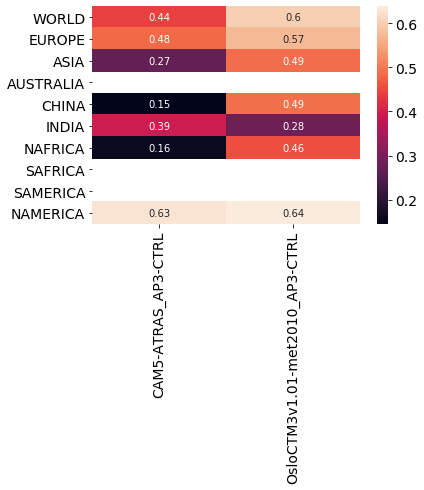

In [24]:
sns.heatmap( df['R'], annot = True, center = None)

In [31]:
df

R                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD                0.440344                       0.600833   
EUROPE               0.484294                       0.574396   
ASIA                 0.274628                       0.488073   
AUSTRALIA                 NaN                            NaN   
CHINA                0.146049                       0.489111   
INDIA                0.394099                       0.282538   
NAFRICA              0.159901                       0.455872   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA             0.627173                       0.638068   

                    R_kendall                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD                0.491196                       0.504234   
EUROPE               0.415567                       0.437267   
ASIA                 0.362894                       0.398494   
AUSTRALIA                 NaN                            NaN   
CHINA                0.353330                       0.429839   
INDIA                0.342999                       0.342999   
NAFRICA              0.165837                       0.312855   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA             0.532699                       0.529451   

                   R_spearman                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD                0.670300                       0.683869   
EUROPE               0.582366                       0.611304   
ASIA                 0.492627                       0.559859   
AUSTRALIA                 NaN                            NaN   
CHINA                0.435350                       0.582455   
INDIA                0.479118                       0.509393   
NAFRICA              0.234634                       0.438192   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA             0.727483                       0.720139   

                    data_mean                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL   
WORLD            3.151448e-11                   1.631661e-11   
EUROPE           3.008709e-11                   1.831768e-11   
ASIA             1.209218e-10                   4.274041e-11   
AUSTRALIA                 NaN                            NaN   
CHINA            2.145614e-10                   6.155913e-11   
INDIA            7.409971e-11                   3.376930e-11   
NAFRICA          1.648878e-11                   7.903444e-12   
SAFRICA                   NaN                            NaN   
SAMERICA                  NaN                            NaN   
NAMERICA         2.669231e-11                   1.429629e-11   

                     data_std                                 ...  \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTRL  ...   
WORLD            5.036058e-11                   1.408129e-11  ...   
EUROPE           3.157894e-11                   1.105397e-11  ...   
ASIA             1.893539e-10                   4.030673e-11  ...   
AUSTRALIA                 NaN                            NaN  ...   
CHINA            2.729316e-10                   5.046387e-11  ...   
INDIA            8.563198e-11                   2.948105e-11  ...   
NAFRICA          1.465755e-11                   5.011975e-12  ...   
SAFRICA                   NaN                            NaN  ...   
SAMERICA                  NaN                            NaN  ...   
NAMERICA         2.172303e-11                   9.345690e-12  ...   

                    num_valid                                 \
          CAM5-ATRAS_AP3-CTRL OsloCTM3v1.01-met2010_AP3-CTR

uses copy


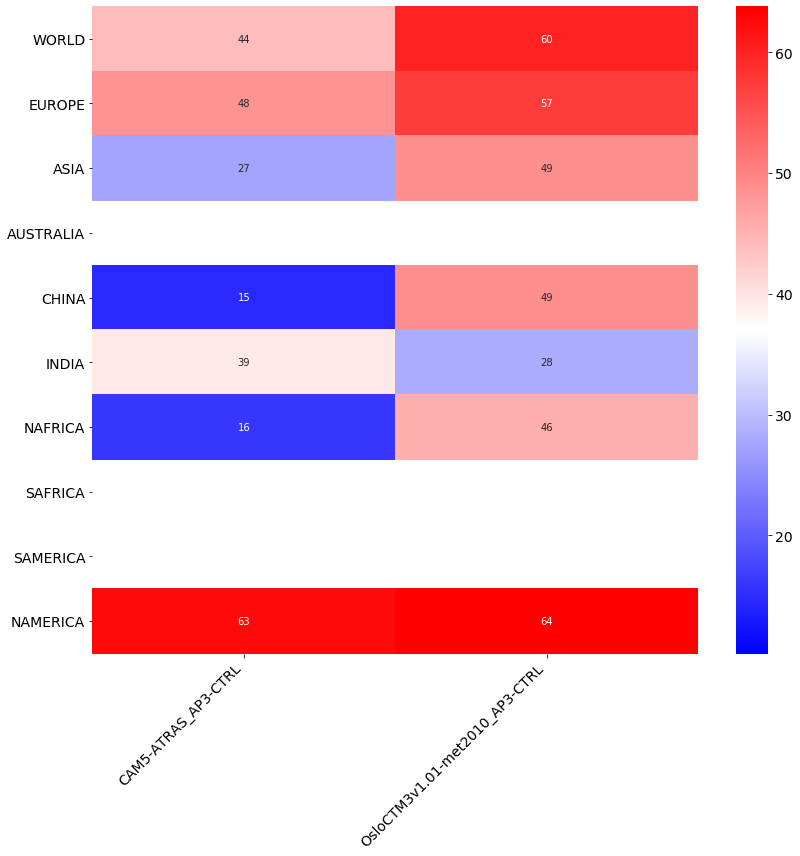

In [30]:
df_to_heatmap(df['R']*100, annot = True, color_rowwise=False, cbar = True, center = 0)

In [ ]:
test = df['R_spearman']

In [ ]:
models = test.index.values

In [ ]:
regions = test.columns.values

In [ ]:
pd.MultiIndex.from_product([test.index.values, test.columns.values], names=['model', 'region'])

In [ ]:
idxeses = pd.MultiIndex.from_product([test.index.values, test.columns.values], names=['model', 'region']).codes

In [ ]:
len(regions[idxeses[1]])

In [ ]:
len(models[idxeses[0]])

In [ ]:
df['num_stations'].values.reshape(-1)

In [ ]:
df['R_spearman'].values.reshape(-1)

In [ ]:
sizes  = df['num_stations'].values.reshape(-1)
values = df['R_spearman'].values.reshape(-1)

In [ ]:
df = pd.DataFrame.from_dict({'region': regions[idxeses[1]], 
                            'model': models[idxeses[0]], 
                            'size':sizes, 
                            'values':values})

In [ ]:
df.head()

In [ ]:
#sns.diverging_palette?

In [ ]:
#fig, axes = plt.figure(figsize = (20,12))
ax = heatmap(x = df['region'].values, 
             y = df['model'].values, 
             values = df['values'].values,
             size = df['size'].values, 
             title = 'Model inter comparison, Correlation Coefficients R spearman',
             palette = sns.diverging_palette(20, 220, n=256), 
             marker = 'o', colorbar = True)
#ax.legend()

In [ ]:
ax_ctm3 = df_to_heatmap(df['R_spearman'], cbar = True, num_digits=3)

ax_ctm3.set_title('Spreaman correlation coefficient')
#ax_ctm3.scatter(, df['num_stations'].values,  c="crimson", s=100)

In [ ]:
ax_ctm3 = df_to_heatmap(df['fge'], cbar = True, num_digits=3)

# Save for later 

In [ ]:
vars_to_retrieve = 'wetso4'
OBS_network = 'GAWTADsubsetAasEtAl'
list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL']
add_yearly = 'mean'
start = 2010
bias = True 
rmse = True
region = 'NAMERICA'

ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)

# TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).

if region is not None:
    f              = Filter(region=region)
    ungridded_data = f(ungridded_data)

station_names     = ungridded_data.station_name # Is this used anymore. 
list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                     for ID in list_model_ID ]


# calc_statistics() -- returns one value for.

# Possible to retrieve ts type of obeservation 
list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, 
                                                           ungridded_data, 
                                                           ts_type='monthly') # calc_statistics()
                for gridded_data in list_gridded_data]

#example_stats = list_colocate[0]

# call merged : raw, bias : Bias, rmse : RMSE 
def fix_df(df):
    df = df.unstack('data_source').swaplevel().unstack('station_name')
    df2 = df['wetso4']
    df2.columns = df2.columns.swaplevel(0,1)
    df2.sort_index(axis = 1, level = (0, 1), inplace = True)
    return df2

dataframes = [ coloc.data.to_dataframe().drop(columns=['var_name', 'var_units','ts_type_src','altitude', 
                                                       'latitude', 'longitude']) for coloc in list_colocate ]
dataframes = [fix_df(df) for df in dataframes]

seasonal_means = [coloc.data.groupby('time.season').mean(dim = 'time', skipna = True) for coloc in list_colocate]
df_seasons = [fix_df(seasonal_mean.to_dataframe()) for seasonal_mean in seasonal_means]

for i in range(len(dataframes)):
    # Append yearly mean
    dataframes[i]       = dataframes[i].append( dataframes[i].mean(axis = 0), ignore_index = True)
    # Appends seasonal averages
    dataframes[i]       = dataframes[i].append( df_seasons[i], ignore_index = True)
    # Updates index 
    dataframes[i].index = np.concatenate([np.arange(12), ['year', 'DJF', 'MAM', 'JJA', 'SON']])

lala = pd.concat(dataframes, axis = 1) # Merged dataframes containing diffent models.
lala.sort_index(axis = 1, level = (0, 1), inplace = True) # Sort index
df = lala.loc[:, ~lala.columns.duplicated()] # Removes duplicates
# In this case the obsevations are duplicated, since they are present in both model comparison.
df_to_heatmap(df.iloc[:, :10]['Abington (CT15)'], num_digits=12)

In [ ]:
 example_stats.data['Abington (CT15)']

# Example from __init__( ) in colocated data. 

In [ ]:
import matplotlib.pyplot as plt
import pyaerocom as pya
plt.close('all')
obsdata = pya.io.ReadUngridded().read('AeronetSunV3Lev2.daily', 'od550aer')
modeldata = pya.io.ReadGridded('ECMWF_CAMS_REAN').read_var('od550aer', start=2010)

coldata1 = pya.colocation.colocate_gridded_ungridded(modeldata, obsdata, 
                                                    ts_type='monthly',
                                                    start=2010,
                                                    var_outlier_ranges={'od550aer':[0,10]},
                                                    filter_name='WORLD-noMOUNTAINS',
                                                    remove_outliers=True, 
                                                    colocate_time=False)

sat = pya.io.ReadGridded('MODIS6.aqua').read_var('od550aer', start=2010)

coldata2 = pya.colocation.colocate_gridded_gridded(modeldata, sat, 
                                                   ts_type='monthly',
                                                   regrid_res_deg=10)

sat_namerica = coldata2.apply_latlon_filter(region_id='NAMERICA')
sat_namerica.plot_scatter()
sat_namerica.plot_coordinates()

coldata1.plot_scatter()

stats = {}
for region_id in pya.region.get_all_default_region_ids():
    filtered = coldata1.apply_latlon_filter(region_id=region_id)
    stats[region_id] = filtered.calc_statistics()
print('AERONET')    
for r, s in stats.items():
    if s['num_valid'] == 0:
        print('No data in region {}'.format(r))
    else:
        print('{}: NMB={:.3f} (R={:.2f})'.format(r, s['nmb']*100, s['R']))

stats = {}
for region_id in pya.region.get_all_default_region_ids():
    filtered = coldata2.apply_latlon_filter(region_id=region_id)
    stats[region_id] = filtered.calc_statistics()
print('MODIS')    
for r, s in stats.items():
    if s['num_valid'] == 0:
        print('No data in region {}'.format(r))
    else:
        print('{}: NMB={:.3f} (R={:.2f})'.format(r, s['nmb']*100, s['R']))


In [ ]:
list_colocate[0].calc_statistics() # Statistics of a ensamble of data. 

In [ ]:
stats = {}
for region_id in pya.region.get_all_default_region_ids():
    filtered = coldata1.apply_latlon_filter(region_id=region_id)
    stats[region_id] = list_colocate[0].calc_statistics()

In [ ]:
df.rename(columns={"GAWTADsubsetAasEtAl": "obs", 
                   "CAM5-ATRAS_AP3-CTRL": "CAM5", 
                   "OsloCTM3v1.01-met2010_AP3-CTRL": "OsloCTM3"}, inplace = True)

In [ ]:
station_names[:10] 

In [ ]:
for station_name in station_names:
    df[station_name]
    

In [ ]:
df_to_heatmap(df.iloc[:, :10]['Abington (CT15)'], num_digits=12, cbar = True)

In [ ]:
calc_statistics?

In [ ]:
df.columns

In [ ]:
#df.sort_index(axis = 1, level = (0, 1), inplace = True)

In [ ]:
#df.append(df.sum().rename('Total')).assign(Total=lambda d:d.sum(1))

In [ ]:
#df = construct_df_model_intercomparison_to_observations(region = 'NAMERICA', bias = True, rmse = True)

In [ ]:
vars_to_retrieve = 'wetso4'
OBS_network = 'GAWTADsubsetAasEtAl'
list_model_ID = ['OsloCTM3v1.01-met2010_AP3-CTRL', 'CAM5-ATRAS_AP3-CTRL']
add_yearly = 'mean'
start = 2010
bias = True 
rmse = True 
region = None

In [ ]:
ungridded_data = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)

# TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).

station_names = ungridded_data.station_name
gridded_data  = pya.io.ReadGridded('OsloCTM3v1.01-met2010_AP3-CTRL').read(vars_to_retrieve = [vars_to_retrieve], start = start)[0]

# Possible to retrieve ts type of obeservation 
colocate = pya.colocation.colocate_gridded_ungridded(gridded_data, ungridded_data, ts_type='monthly')

In [ ]:
m.data

In [ ]:
stats = colocate.calc_statistics()

In [ ]:
stats

In [ ]:
ungridded_data    = ReadUngridded().read(datasets_to_read = OBS_network, vars_to_retrieve = vars_to_retrieve)

# TODO collocated dataobject can now done by collocated data object, much less stuff to filter by (faster).
if region is not None:
    f              = Filter(region=region)
    ungridded_data = f(ungridded_data)

station_names     = ungridded_data.station_name
list_gridded_data = [pya.io.ReadGridded(ID).read(vars_to_retrieve = [vars_to_retrieve], start = start)[0] 
                     for ID in list_model_ID ]

# Possible to retrieve ts type of obeservation 
list_colocate = [pya.colocation.colocate_gridded_ungridded(gridded_data, ungridded_data, ts_type='monthly')
                for gridded_data in list_gridded_data]

# call merged : raw, bias : Bias, rmse : RMSE 
def fix_df(df):
    df = df.unstack('data_source').swaplevel().unstack('station_name')
    df2 = df['wetso4']
    df2.columns = df2.columns.swaplevel(0,1)
    df2.sort_index(axis = 1, level = (0, 1), inplace = True)
    return df2

dataframes = [ coloc.data.to_dataframe().drop(columns=['var_name', 'var_units','ts_type_src','altitude', 
                                                       'latitude', 'longitude']) for coloc in list_colocate ]

In [ ]:
list_colocate[0]

In [ ]:
#list_colocate[0].data

In [ ]:
seasonal_means = [ coloc.data.groupby('time.season').mean(dim='time') for coloc in list_colocate ]

In [ ]:
df = dataframes[0]
coloc_season = seasonal_means[0]

In [ ]:
fix_df(seasonal_means[0].to_dataframe())

In [ ]:
fix_df(df).index 

In [ ]:
coloc_season

In [ ]:
coloc_season = seasonal_means[1]

In [ ]:
coloc_season.values

In [ ]:
coloc_season['season'].values

In [ ]:
for name, g in coloc_season:
    print(g)
#coloc_season.DFJ